##  Load the files

In [14]:
import pandas as pd
import numpy as np
import cv2
import os

# Paths
root = r"C:\DeepLabCutProjects\DLC-Atanu-2024-12-25\Analyzed-videos-filtered"
files = [
    # "Food_Only_Gen_2_2_11_25_S4_Y_CNO____Paris_London_Phoenix_None4_____Trial_1_bottom_left.csv",
    "Food_Only_Gen_2_2_11_25_S2_Y_CNO____Denver_ElPaso_Waco_None4_____Trial_1_bottom_left.csv"
]
full_paths = [os.path.join(root, f) for f in files]


## Define reference unit square

In [15]:
# Target unit square corners (clockwise: top-left → top-right → bottom-right → bottom-left)
unit_square = np.array([
    [1, 0],
    [0, 0],
    [0, 1],
    [1, 1]
], dtype=np.float32)

## Process each file: compute homography & transform head

In [ ]:
# Color map
color_map = {
    'Corner1': 'red',
    'Corner2': 'blue',
    'Corner3': 'green',
    'Corner4': 'purple',
    'Head': 'black'
}


Processing: Food_Only_Gen_2_2_11_25_S2_Y_CNO____Denver_ElPaso_Waco_None4_____Trial_1_bottom_left.csv
[[ 8.31542805e-03 -3.56668692e-05 -2.18342895e-01]
 [-3.24543190e-04  8.59912980e-03 -6.20120644e-02]
 [-1.20883357e-04  1.66846901e-04  1.00000000e+00]]
[9.84620185e-01 2.63677968e-16 9.84620185e-01]
[4.44089210e-16 3.26128013e-16 9.98190416e-01]
[4.71844785e-16 1.01788195e+00 1.01788195e+00]
[1.00377482 1.00377482 1.00377482]


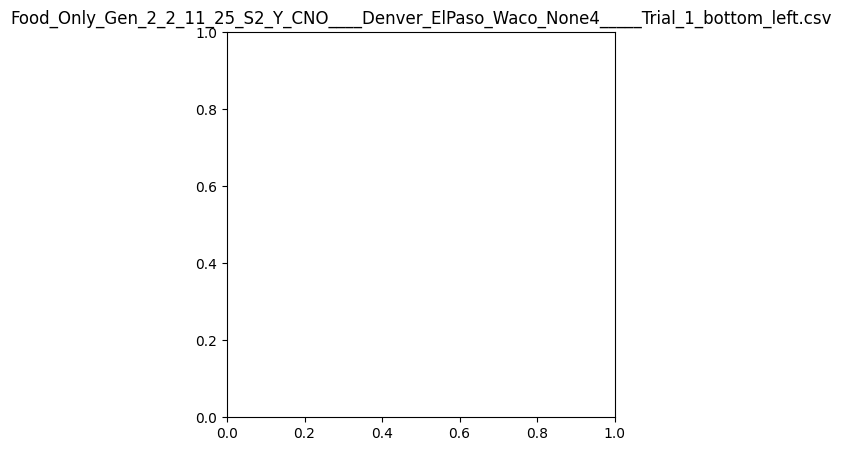

In [28]:
# Process each file
for path in full_paths:
    df = pd.read_csv(path, header=[1, 2])
    print(f"\nProcessing: {os.path.basename(path)}")

    # Step 1: Compute average corner positions (after likelihood filter)
    src_pts = []
    for corner in ['Corner1', 'Corner2', 'Corner3', 'Corner4']:
        lx = df[(corner, 'x')]
        ly = df[(corner, 'y')]
        ll = df[(corner, 'likelihood')]
        mask = ll > 0.9
        if mask.sum() == 0:
            print(f"Warning: no high-confidence points for {corner}")
            src_pts.append([np.nan, np.nan])
        else:
            src_pts.append([lx[mask].mean(), ly[mask].mean()])
    src_pts = np.array(src_pts, dtype=np.float32)
    
    # Skip if any corner could not be computed
    if np.isnan(src_pts).any():
        print("⚠️ Skipping file due to invalid corner data.")
        continue

    # Step 2: Compute homography to unit square
    H, _ = cv2.findHomography(src_pts, unit_square)
    print(H)

    # Step 3: Plot normalized points
    plt.figure(figsize=(5, 5))
    plt.title(os.path.basename(path))

    # Plot corners (in normalized space, as single points)
    for i, corner in enumerate(['Corner1', 'Corner2', 'Corner3', 'Corner4']):
        cx, cy = src_pts[i]
        warped = H @ np.array([cx, cy, 1.0])
        print(warped)
        warped /= warped[2]
        plt.scatter(warped[0], warped[1], s=80, color=color_map[corner], label=corner, marker='X')

    # Transform and plot Head trajectory
    xh = df[('Head', 'x')]
    yh = df[('Head', 'y')]
    lh = df[('Head', 'likelihood')]
    mask = lh > 0.9
    if mask.sum() > 0:
        points = np.vstack([xh[mask], yh[mask], np.ones(mask.sum())])
        warped = H @ points
        warped /= warped[2]
        plt.scatter(warped[0], warped[1], s=5, color=color_map['Head'], alpha=0.6, label='Head')

    plt.xlabel("x (normalized)")
    plt.ylabel("y (normalized)")
    plt.grid(True)
    # plt.legend()
    plt.tight_layout()
    plt.show()

In [30]:
!python ../Python_scripts/normalizeCSV.py


Finished normalization. Log saved to: C:\DeepLabCutProjects\DLC-Atanu-2024-12-25\Analyzed-videos-filtered\NormalizedCSVs\normalization_log.txt



Normalizing CSVs: 100%|##########| 922/922 [20:48<00:00,  1.35s/it]
